In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics

# from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, roc_results
from lob_data_utils.svm_calculation import lob_svm
import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
data_length = 15000
rs_params = [(0.1, 1.0), (1.0, 0.1), (1.0, 1.0), (0.1, 0.1)]
stocks = list(roc_results.result_cv_15000.keys())
data_dir = 'res_pca_gdf3_15000'

In [13]:
def get_mean_scores(scores: dict) -> dict:
    mean_scores = {}
    for k, v in scores.items():
        mean_scores[k] = np.mean(v)
    return mean_scores

def get_score_for_clf(clf, df_test):
    x_test = df_test[['queue_imbalance']]
    y_test = df_test['mid_price_indicator'].values
    return model.test_model(clf, x_test, y_test)

def get_logistic_regression(stock, data_length):
    df, df_test = lob.load_prepared_data(
        stock, data_dir='../gaussian_filter/data', cv=False, length=data_length)
    clf = LogisticRegression()
    train_x = df[['queue_imbalance']]

    scores = model.train_model(clf, train_x, df['mid_price_indicator'], prefix='log')
    res = {
        **scores,
        'stock': stock,
        'kernel': 'logistic',
    }
    test_scores = get_score_for_clf(clf, df_test)
    return {**res, **test_scores}

In [50]:
df_res = pd.DataFrame()
for stock in stocks:
    for r, s in rs_params:
    #pd.read_csv('svm_features_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s))
        filename = data_dir + '/svm_pca_gdf_rbf_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s)
        if os.path.exists(filename):
            df_temp = pd.read_csv(filename)
            df_temp['r'] = [r] * len(df_temp)
            df_temp['s'] = [s] * len(df_temp)
            df_res = df_res.append(df_temp)
#df_res.drop(columns=['Unnamed: 0'], inplace=True)
columns = ['C', 'f1', 'features', 'gamma', 'kappa',
           'matthews', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_roc_auc', 'r', 's']
df_res[columns].sort_values(by='roc_auc', ascending=False).groupby('stock').head(1)

,C,f1,features,gamma,kappa,matthews,roc_auc,stock,test_f1,test_kappa,test_matthews,test_roc_auc,r,s
25,1.0,0.515652,pca_gdf_que3,10.000,0.125300,0.131140,0.562778,9063,0.540872,0.101277,0.101421,0.550654,0.1,1.0
35,100.0,0.554260,pca_gdf_que3,0.001,0.122789,0.124221,0.561466,9269,0.518648,0.080288,0.080814,0.540207,1.0,0.1
29,10.0,0.547379,pca_gdf_que3,0.010,0.117992,0.118985,0.559184,10166,0.552840,0.096954,0.096956,0.548475,1.0,1.0
28,10.0,0.549560,pca_gdf_que3,0.001,0.113247,0.114033,0.556814,9067,0.559267,0.102080,0.102083,0.551049,1.0,0.1
29,10.0,0.559908,pca_gdf_que3,0.010,0.111066,0.111811,0.555656,9265,0.573558,0.122324,0.122516,0.561159,0.1,1.0
35,100.0,0.558368,pca_gdf_que3,0.001,0.108160,0.108422,0.554114,12059,0.554925,0.111334,0.111409,0.555707,1.0,1.0
19,0.1,0.518944,pca_gdf_que3,100.000,0.103491,0.105065,0.551907,9058,0.513755,0.056353,0.056378,0.528164,1.0,0.1
28,10.0,0.549703,pca_gdf_que3,0.001,0.100214,0.101303,0.550179,9069,0.560342,0.108223,0.108230,0.554106,1.0,1.0
44,1000.0,0.475939,pca_gdf_que3,0.100,0.099728,0.106398,0.550084,9061,0.458604,0.051907,0.053432,0.525907,0.1,0.1
17,0.1,0.557671,pca_gdf_que3,1.000,0.085519,0.085808,0.542762,9064,0.590282,0.085705,0.087274,0.542710,0.1,1.0


In [21]:
log_res = []
for stock in stocks:
    log_res.append(get_logistic_regression(stock, data_length))
df_log_res = pd.DataFrame(log_res)
df_log_res['stock'] = df_log_res['stock'].values.astype(np.int)
df_log_res.index = df_log_res['stock'].values.astype(np.int)

,kernel,log_f1,log_kappa,log_matthews,log_precision,log_recall,log_roc_auc,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc
9069,logistic,0.564810,0.100714,0.100788,0.554517,0.575493,0.550331,9069,0.581841,0.127420,0.127716,0.563467,0.601454,0.563673
9063,logistic,0.559720,0.120842,0.120846,0.561736,0.557718,0.560422,9063,0.548213,0.106820,0.106885,0.557996,0.538767,0.553421
9094,logistic,0.547765,0.116035,0.116079,0.555632,0.540118,0.558003,9094,0.561415,0.124002,0.124003,0.562542,0.560293,0.562001
10166,logistic,0.561307,0.118660,0.118663,0.559358,0.563270,0.559329,10166,0.562982,0.092885,0.093053,0.547158,0.579749,0.546422
9061,logistic,0.544554,0.096124,0.096126,0.546527,0.542594,0.548061,9061,0.517372,0.064292,0.064364,0.530324,0.505037,0.532135
9064,logistic,0.561085,0.081747,0.081916,0.544413,0.578809,0.540840,9064,0.578768,0.090512,0.091167,0.548387,0.612713,0.545162
11244,logistic,0.573988,0.069200,0.069807,0.541372,0.610785,0.534495,11244,0.589949,0.074227,0.075412,0.547159,0.640000,0.536897
9062,logistic,0.561310,0.069748,0.070046,0.537939,0.586803,0.534833,9062,0.563452,0.081828,0.082101,0.542456,0.586139,0.540881
9067,logistic,0.576594,0.108692,0.108940,0.558697,0.595675,0.554283,9067,0.561142,0.097332,0.097336,0.558425,0.563885,0.548655
9265,logistic,0.574809,0.106566,0.106824,0.556427,0.594448,0.553229,9265,0.568380,0.109928,0.110122,0.552483,0.585220,0.554960


In [15]:
df_gdf_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_gdf_best['stock'] = df_gdf_best['stock'].values.astype(np.int)
df_gdf_best.index = df_gdf_best['stock'].values.astype(np.int)

In [41]:
df_all = pd.merge(df_gdf_best, df_log_res, on='stock', suffixes=['_svm', '_log'])
df_all.rename(columns=
              {
                  'matthews': 'matthews_svm', 
                  'log_matthews': 'matthews_log',
                  'roc_auc': 'roc_auc_svm',
                  'log_roc_auc': 'roc_auc_log',
                  'f1': 'f1_svm',
                  'log_f1': 'f1_log',
              
              }, inplace=True)

In [42]:
df_all.columns

Index(['C', 'f1_svm', 'features', 'gamma', 'kappa', 'matthews_svm',
       'roc_auc_svm', 'stock', 'test_f1_svm', 'test_kappa_svm',
       'test_matthews_svm', 'test_roc_auc_svm', 'r', 's', 'kernel', 'f1_log',
       'log_kappa', 'matthews_log', 'log_precision', 'log_recall',
       'roc_auc_log', 'test_f1_log', 'test_kappa_log', 'test_matthews_log',
       'test_precision', 'test_recall', 'test_roc_auc_log'],
      dtype='object')

In [43]:
all_columns = [ 'features', 'matthews_svm', 'matthews_log',  'test_matthews_svm',  'test_matthews_log',
       'roc_auc_svm', 'roc_auc_log', 'test_roc_auc_svm',  'test_roc_auc_log', 'stock', 
               'f1_svm', 'f1_log', 'test_f1_svm', 'test_f1_log', 'r', 's']
df_all[all_columns]

,features,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock,f1_svm,f1_log,test_f1_svm,test_f1_log,r,s
0,pca_gdf_que3,0.131140,0.120846,0.101421,0.106885,0.562778,0.560422,0.550654,0.553421,9063,0.515652,0.559720,0.540872,0.548213,0.1,1.0
1,pca_gdf_que3,0.124774,0.114746,0.086088,0.093791,0.560794,0.557149,0.542554,0.546355,9269,0.531390,0.531909,0.507698,0.511461,1.0,1.0
2,pca_gdf_que3,0.118985,0.118663,0.096956,0.093053,0.559184,0.559329,0.548475,0.546422,10166,0.547379,0.561307,0.552840,0.562982,1.0,1.0
3,pca_gdf_que3,0.114033,0.108940,0.102083,0.097336,0.556814,0.554283,0.551049,0.548655,9067,0.549560,0.576594,0.559267,0.561142,1.0,0.1
4,pca_gdf_que3,0.111811,0.106824,0.122516,0.110122,0.555656,0.553229,0.561159,0.554960,9265,0.559908,0.574809,0.573558,0.568380,0.1,1.0
5,pca_gdf_que3,0.108422,0.108065,0.111409,0.112908,0.554114,0.554021,0.555707,0.556449,12059,0.558368,0.547866,0.554925,0.546694,1.0,1.0
6,pca_gdf_que3,0.106398,0.096126,0.053432,0.064364,0.550084,0.548061,0.525907,0.532135,9061,0.475939,0.544554,0.458604,0.517372,0.1,0.1
7,pca_gdf_que3,0.105065,0.097540,0.056378,0.073676,0.551907,0.548669,0.528164,0.536782,9058,0.518944,0.565371,0.513755,0.545870,1.0,0.1
8,pca_gdf_que3,0.101950,0.100788,0.108430,0.127716,0.548358,0.550331,0.552964,0.563673,9069,0.578027,0.564810,0.598439,0.581841,1.0,1.0
9,pca_gdf_que3,0.086370,0.081916,0.090129,0.091167,0.542536,0.540840,0.544634,0.545162,9064,0.570978,0.561085,0.578850,0.578768,0.1,1.0


In [44]:
df_all['matthews_diff'] = df_all['matthews_svm'] -  df_all['matthews_log']
df_all['matthews_test_diff'] = df_all['test_matthews_svm'] - df_all['test_matthews_log']

In [29]:
result_cv_15000 = {'9069': 0.56266492905467125, '9063': 0.55890612062034239,
                   '9094': 0.56271758343003708,
                   '10166': 0.54209270809674659, '9061': 0.53172059475198441,
                   '9064': 0.5445462725690029,
                   '11244': 0.53511679644048948, '9062': 0.54049738307164052,
                   '9067': 0.54498044328552808,
                   '9265': 0.55580632143346032, '9058': 0.53573417928037304,
                   '9269': 0.54865753911806547,
                   '12059': 0.55367480325463525}
stocks15000 = np.array(list(result_cv_15000.keys())).astype(np.int)

In [45]:
df_all.loc[df_all[df_all['stock'].isin(stocks15000)]['matthews_diff'].nlargest(n=2).index]

,C,f1_svm,features,gamma,kappa,matthews_svm,roc_auc_svm,stock,test_f1_svm,test_kappa_svm,...,log_recall,roc_auc_log,test_f1_log,test_kappa_log,test_matthews_log,test_precision,test_recall,test_roc_auc_log,matthews_diff,matthews_test_diff
0,1.0,0.515652,pca_gdf_que3,10.0,0.125300,0.131140,0.562778,9063,0.540872,0.101277,...,0.557718,0.560422,0.548213,0.106820,0.106885,0.557996,0.538767,0.553421,0.010295,-0.005464
6,1000.0,0.475939,pca_gdf_que3,0.1,0.099728,0.106398,0.550084,9061,0.458604,0.051907,...,0.542594,0.548061,0.517372,0.064292,0.064364,0.530324,0.505037,0.532135,0.010271,-0.010932


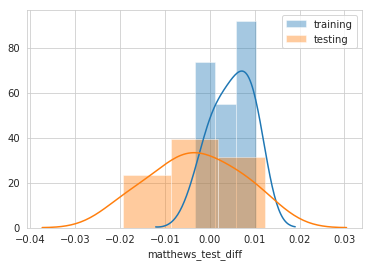

In [46]:
sns.distplot(df_all['matthews_diff'], label='training')
sns.distplot(df_all['matthews_test_diff'], label='testing')
plt.legend()

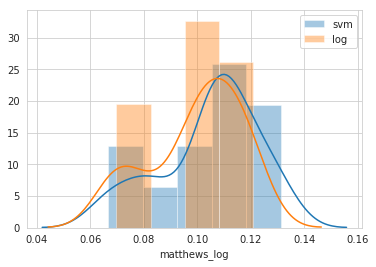

In [47]:
sns.distplot(df_all['matthews_svm'], label='svm')
sns.distplot(df_all['matthews_log'], label='log')
plt.legend()

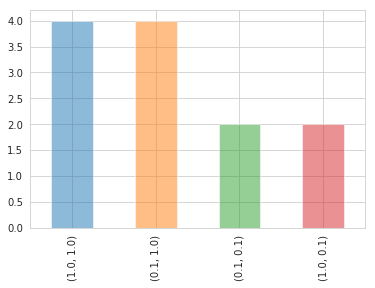

In [34]:
df_all['rs'] = list(zip(df_all['r'], df_all['s']))
df_all['rs'].value_counts().plot(kind='bar', alpha=0.5, stacked=False)

In [35]:
df_all['matthews_diff'].median(), df_all['matthews_test_diff'].median()

(0.005040456524563801, -0.0034813763207104526)

In [48]:
len(df_all[df_all['matthews_svm'] > df_all['matthews_log']][all_columns]), len(df_all[df_all['test_matthews_svm'] > df_all['test_matthews_log']]), len(df_all)

(11, 4, 12)

In [49]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

,features,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock,f1_svm,f1_log,test_f1_svm,test_f1_log,r,s
0,pca_gdf_que3,0.131140,0.120846,0.101421,0.106885,0.562778,0.560422,0.550654,0.553421,9063,0.515652,0.559720,0.540872,0.548213,0.1,1.0
1,pca_gdf_que3,0.124774,0.114746,0.086088,0.093791,0.560794,0.557149,0.542554,0.546355,9269,0.531390,0.531909,0.507698,0.511461,1.0,1.0
5,pca_gdf_que3,0.108422,0.108065,0.111409,0.112908,0.554114,0.554021,0.555707,0.556449,12059,0.558368,0.547866,0.554925,0.546694,1.0,1.0
6,pca_gdf_que3,0.106398,0.096126,0.053432,0.064364,0.550084,0.548061,0.525907,0.532135,9061,0.475939,0.544554,0.458604,0.517372,0.1,0.1
7,pca_gdf_que3,0.105065,0.097540,0.056378,0.073676,0.551907,0.548669,0.528164,0.536782,9058,0.518944,0.565371,0.513755,0.545870,1.0,0.1
8,pca_gdf_que3,0.101950,0.100788,0.108430,0.127716,0.548358,0.550331,0.552964,0.563673,9069,0.578027,0.564810,0.598439,0.581841,1.0,1.0
9,pca_gdf_que3,0.086370,0.081916,0.090129,0.091167,0.542536,0.540840,0.544634,0.545162,9064,0.570978,0.561085,0.578850,0.578768,0.1,1.0
11,pca_gdf_que3,0.066731,0.070046,0.075877,0.082101,0.532814,0.534833,0.537295,0.540881,9062,0.571990,0.561310,0.578899,0.563452,0.1,1.0


In [ ]:
len(df_all[df_all['roc_auc_svm'] > df_all['roc_auc_log']][all_columns]), len(df_all[df_all['test_roc_auc_svm'] > df_all['test_roc_auc_log']][all_columns]), len(df_all)

In [ ]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

In [ ]:
df_all[df_all['test_roc_auc_svm'] < df_all['test_roc_auc_log']][all_columns]